In [3]:
import numpy as np
import torch
from torch.nn import BatchNorm2d, Conv1d, Conv2d, ModuleList, Parameter
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.models import RGCN_v1
from utils.xai_utils import integrated_gradients
import seaborn as sns

plt.style.use('dark_background')

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [4]:
river_dl = np.load("../../river-dl/results/baseline/RGCN/prepped.npz")

x = torch.from_numpy(river_dl['x_trn']).float()[-455:] # use the last year of data for all 455 segments
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:]

ajd_matrix = river_dl['dist_matrix']
batch_size = ajd_matrix.shape[0]

x.shape, y.shape, ajd_matrix.shape

(torch.Size([455, 180, 7]), torch.Size([455, 180, 1]), (455, 455))

# Define RGCN v1

In [5]:
model = RGCN_v1(7, 20, ajd_matrix)
model.load_state_dict(torch.load('../../river-dl/results/baseline/RGCN/rep_5/finetuned_weights.pth', map_location='cpu'))
# Apply XAI and visualize

<All keys matched successfully>

In [6]:
n_series = river_dl['x_trn'].shape[0]
baseline = river_dl['x_trn'].reshape(n_series//455,455,180,7)

In [7]:
baseline=torch.from_numpy(baseline)
baseline=torch.mean(baseline[:,0,...],dim=0).reshape(1,180,7).float()
model.eval()
model(x)
x[0:1].shape, baseline.shape

(torch.Size([1, 180, 7]), torch.Size([1, 180, 7]))

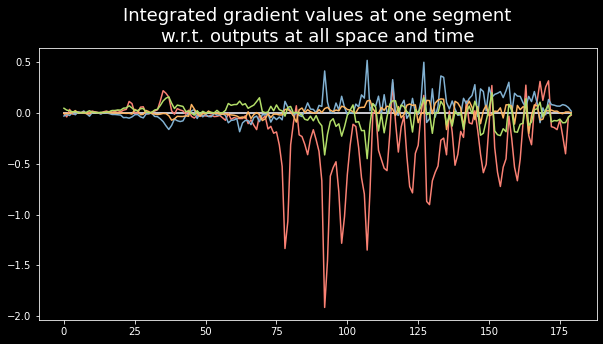

In [72]:
IG_vals = integrated_gradients(x, model, 2, baseline, temporal_focus=range(90,180))

plt.figure(figsize = (10, 5))
for i in range(7):
    plt.plot(IG_vals[0, :, i])
plt.title('Integrated gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18);

In [9]:
time_sum = np.sum(IG_vals,axis=0)
space_sum = np.sum(IG_vals,axis=1)
space_sum.shape, time_sum.shape

((455, 7), (180, 7))

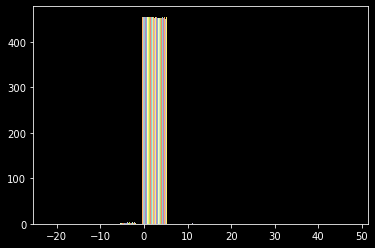

In [15]:
plt.hist(IG_vals[:,:,0])
plt.show()

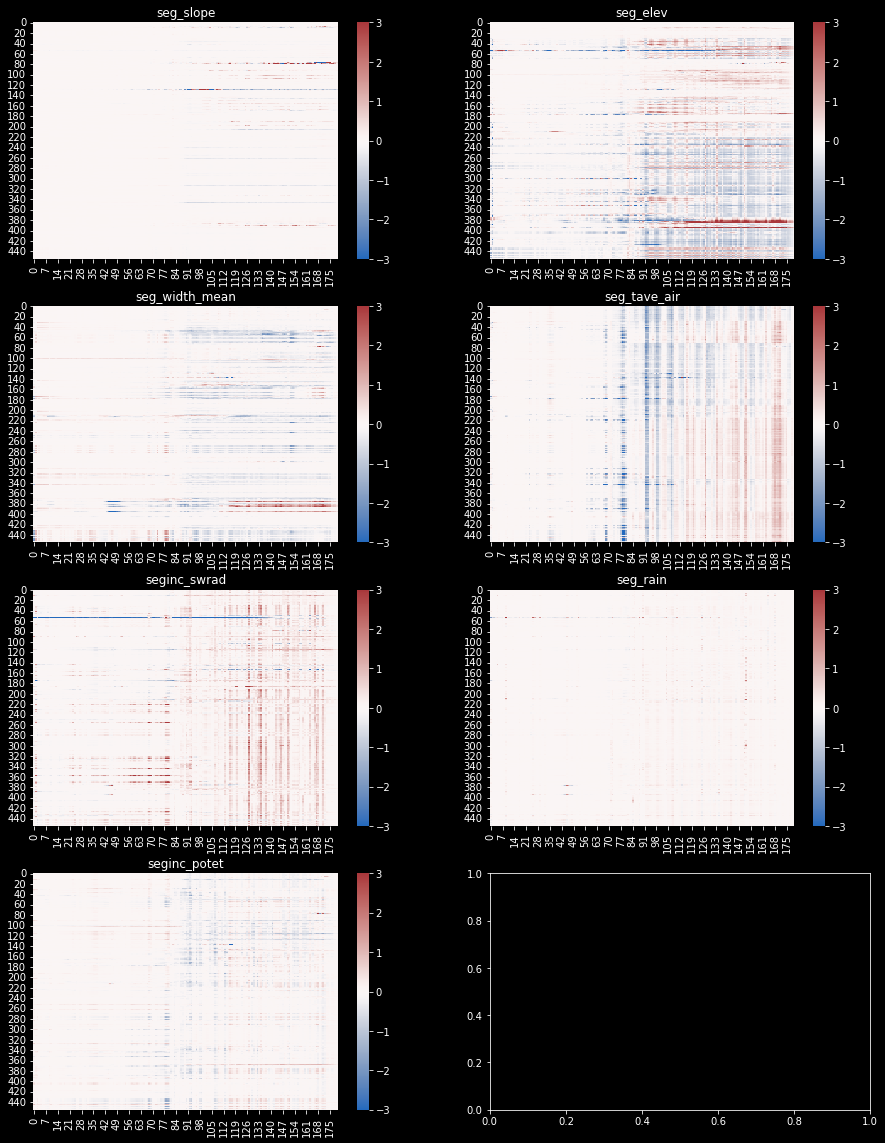

In [73]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(15,20))
#cmap = sns.palplot(sns.diverging_palette(240, 10, n=9))
for i in range(7):
    sns.heatmap(IG_vals[:,:,i], vmin=-3,vmax=3, cmap='vlag', ax=axes.reshape(-1)[i])
    axes.reshape(-1)[i].set_title(river_dl['x_vars'][i])

plt.tight_layout
plt.show()

In [ ]:
attributions = ig.attribute(x[0:1],baseline, n_steps = batch_size, target = -1) # attributions for last day in the sequence

plt.figure(figsize = (11.5, 4))
for i in range(7):
    plt.plot(attributions[0, :, i], label = river_dl['x_vars'][i])
plt.legend(loc = 'upper left')
plt.title('With average baseline')
plt.pause(0.001)

In [9]:
check = x[0]
check2=x[range(4)]
check.shape, check2.shape

(torch.Size([180, 7]), torch.Size([4, 180, 7]))

In [23]:
river_dl['x_vars'][0]

'seg_slope'

## lets try to make a seg to seg heatmap

In [68]:
seg2seg_influence = []
for i in range(455):
    IG_vals = integrated_gradients(x, model, 2, baseline, spatial_focus=i)
    reduced = np.mean(IG_vals,axis=1)
    seg2seg_influence.append(reduced)

In [74]:
check = np.asarray(seg2seg_influence)

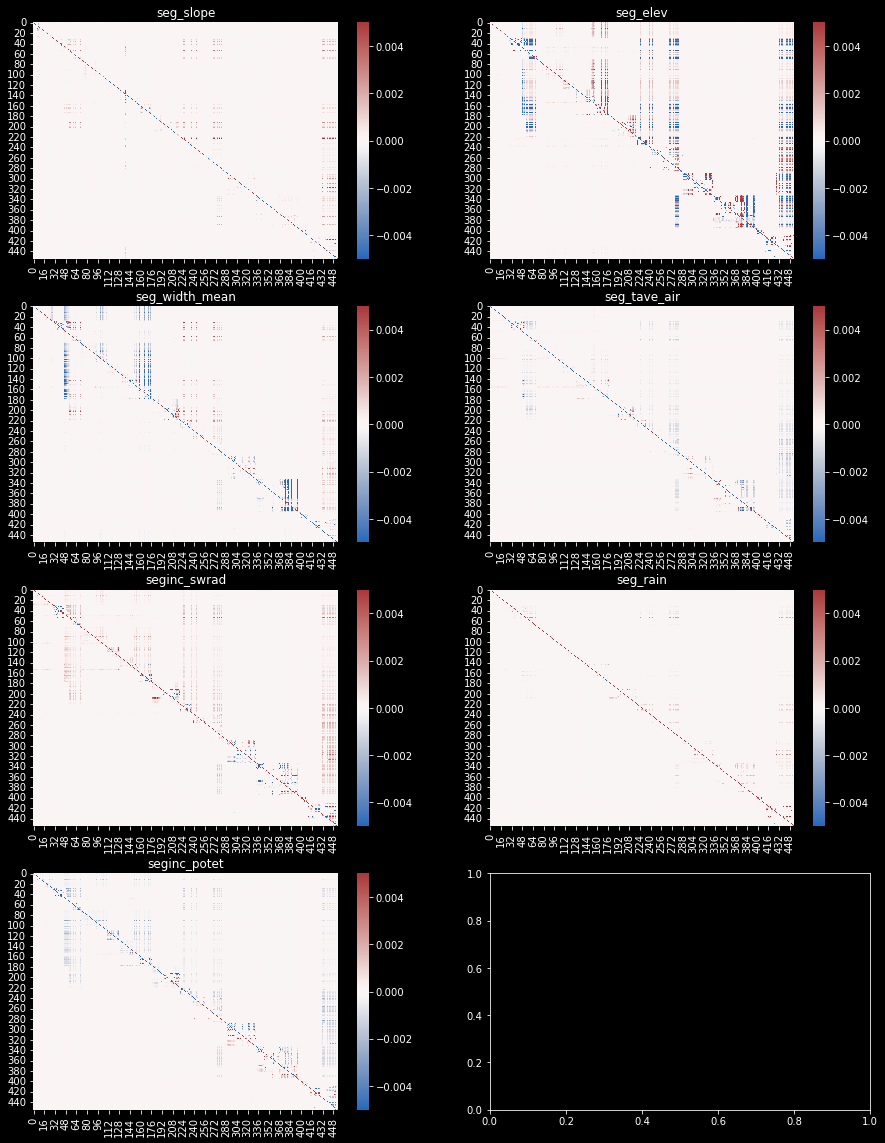

In [82]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(15,20))

for i in range(7):
    sns.heatmap(check[:,:,i], vmin=-.005,vmax=.005, cmap='vlag', ax=axes.reshape(-1)[i])
    axes.reshape(-1)[i].set_title(river_dl['x_vars'][i])

plt.tight_layout
plt.show()

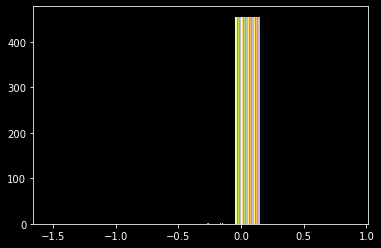

In [78]:
plt.hist(check[:,:,0])
plt.show()